# Evaluating Classifiers

Goals:
1. How to evaluate a machine learning model
2. Understand overfitting
3. Understand cross-validation


## Introduction

Machine learning is different than other types of engineering in that every improvement you make will typically make your model better in some cases and worse in other cases.  It's easy to make choices that seem like they should improve performance but are actually hurting things.  It's very important to not just look at individual examples, but to measure the overall performance of your algorithm at every step. 

Before we make any modifications to the classifier we built, we need to put in place a framework for measuring its accuracy.

## First Attempt

We have 9092 labeled records.  We can try running our algorithm on that data and seeing how many it can correctly predict.

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('../scikit/tweets.csv')

text = df['tweet_text']
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Remove the blank rows:
fixed_target = target[pd.notnull(text)]
fixed_text = text[pd.notnull(text)]

# Perform feature extraction:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(fixed_text)
counts = count_vect.transform(fixed_text)

# Train with this data with a Naive Bayes classifier:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(counts, fixed_target)

predictions = nb.predict(counts)  # predictions is a list of predictions
correct_predictions = sum(predictions == fixed_target) # correct predictions is a count 
print('Percent correct: ', 100.0 * correct_predictions / len(predictions))



Percent correct:  79.5094588649


The naive bayes algorithm gets 79.5% accuracy.

Does this seem like a good way to check the accuracy?  It shouldn't!  We tested our accuracy on the same data we used to fit our model.  This is what is known as testing on training data and it's a cardinal sin in machine learning.

Lets try splitting our data.  We'll train a model on the first 6000 tweets and then test it on the remaining 3092 tweets.


In [13]:
# (Tweets 0 to 5999 are used for training data)
nb.fit(counts[0:6000], fixed_target[0:6000])

# See what the classifier predicts for some new tweets:
# (Tweets 6000 to 9091 are used for testing)
predictions = nb.predict(counts[6000:9092])
print(len(predictions))
correct_predictions = sum(predictions == fixed_target[6000:9092])
print('Percent correct: ', 100.0 * correct_predictions / 3092)

3092
Percent correct:  66.3971539457


## Overfitting

Our accuracy measurement went down a lot - from 79% to 66%.  

Two important questions to ask yourself:
1. Why is testing on training data likely to overestimate accuracy?
2. Why didn't our algorithm get 100% accuracy?

We just checked the accuracy of our algorithm on the data it was trained on.  The algorithm could have memorized every tweet and just spit back what it memorized and gotten 100% accuracy.

For example, here is a model that has high accuracy on the training data and doesn't generalize well.

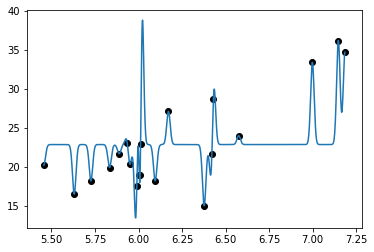

In [11]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

boston_houses = datasets.load_boston() # Load the boston housing price dataset
avg_rooms = boston_houses.data[:20, np.newaxis, 5] # load the average number of rooms for the first 20 records
price = boston_houses.target[:20] # load the price for the first 20 records

# initialize a model
model = GaussianProcessRegressor(
    kernel=C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)),
    normalize_y=True)

# fit the model
model.fit(avg_rooms, price)
X = np.linspace(min(avg_rooms), max(avg_rooms), 1000).reshape(1000,1)
preds = model.predict(X)

plt.scatter(avg_rooms, price,  color='black')
plt.plot(X, preds)


This model goes through every point but wouldn't generalize well to other points.

A model like that does well on the training data but doesn't generalize is doing something known as **overfitting**.

Overfitting is an incredibly common problem in machine learning.  

## Test/Train Splits 

We held out around 30% of our tweets to test on.  But we only have around 9000 tweets.  Two questions to ask yourself:

1. Why might we get unreliable accuracy measurements if we held out 90% of our data as test data?
2. Why might we get unreliable accuracy measurements if we held out only 1% of our data as test data?

Pause for a second and think about this before reading on.  Test your understanding of the code by trying these experiments.

If our held out testing set is too big our model doesn't have enough data to train on, so it will probably perform worse.  

If our held out testing set is too small the measurement will be too noisy - by chance we might get a lot right or a lot wrong.  A 70/30 test train split for smaller data sets is common.  As data sets get bigger it's ok to hold out less data as a percentage.

## Cross Validation

The best way to efficiently use all of our data to measure a model's accuracy is a technique called cross validation.  The way it works is we randomly shuffle our data and then divide it into say 5 equally sized chunks which we call folds.  We hold the first fold out and train on the other folds.  We measure the accuracy of our model on the first fold.  Then we hold out the second fold and train an *entirely new model* and measure its accuracy on the second fold.  We hold out each fold and check its accuracy and then we average all of the accuracies together.  

I find it easier to understand with a diagram.

<img src="images/cross-validation.png" width="600"/>

It's easy to do this in code with the scikit-learn library.


In [24]:
from sklearn.model_selection import cross_val_score

# we pass in model, feature-vector, sentiment-labels and set the number of folds to 10
scores = cross_val_score(nb, counts, fixed_target, cv=10)
print("Accuracy", scores)
print("Average Accuracy", scores.mean())


Accuracy [ 0.65824176  0.63076923  0.60659341  0.60879121  0.64395604  0.68901099
  0.70077008  0.66886689  0.65270121  0.62183021]
Average Accuracy 0.648153102333


It looks like our accuracy is closer to 65%.  Do you think this is good or bad?  

## Baselines

On some tasks, like predicting if the stock market will go up tomorrow or whether a roulette wheel will come up black on the next spin, a 65% accurate model might be incredibly effective and make us rich.  On other tasks like predicting if there will be an earthquake tomorrow, a 65% accurate model could be embarrasingly bad.

A very important thing to consider when we evaluate the performance of our model is how well a very simple model would do.  The simplest model would just guess randomly "No Emotion", "Positive", "Negative" or "Can't Tell" and have 25% accuracy.  A slightly better model would always guess the most common sentiment.

We can use scikit-learns dummy classifiers as baselines to compare against.


In [25]:
# Train with this data with a dummy classifier:
from sklearn.dummy import DummyClassifier
nb = DummyClassifier(strategy='most_frequent')

from sklearn.model_selection import cross_val_score

scores = cross_val_score(nb, counts, fixed_target, cv=10)
print(scores)
print(scores.mean())

[ 0.59230769  0.59230769  0.59230769  0.59230769  0.59230769  0.59230769
  0.5929593   0.5929593   0.59316428  0.59316428]
0.592609330138


The dummy classifier has 59% accuracy, so our model is around six absolute percentage points better than picking the most common category!  It doesn't seem like a lot but I can't tell you the number of times I've seen models that did worse than a dummy classifier.

## Takeaways:
1. When building a machine learning model, get to the evaluation step as quickly as possible.
2. Always compare your model's performance against a baseline.
3. If you don't have an infinite amount of data, use Cross-Validation to evaluate performance.

## Questions

1. Imagine we were trying to predict whether or not an earthquake was going to happen tomorrow - what would the baseline accuracy be?
2. In what scenario would you want to do more folds of cross-validation?  When would you want to do less?
3. Why was the accuray of the dummy classifier consistently 59% while the model we build had accuracy from 60-70%?